# **Importing Data set**

In [1]:
import kagglehub

path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:01<00:00, 2.69MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


# **Importing Tools & Libraries**

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date & time handling
import datetime as dt

# Preprocessing & feature engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

# Models (Regression + Tree-based)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **Data loading & understanding**

In [3]:
df_store = pd.read_csv('/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/stores.csv')
df_features = pd.read_csv('/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/features.csv')
df_train = pd.read_csv('/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/train.csv')
df_test = pd.read_csv('/root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1/test.csv')

In [4]:
df_store.info()
df_store.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_features.info()
df_features.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
df_train.info()
df_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


# **Data preparation (clean room)**

In [7]:
# Ensure proper dtypes
for df in (df_train, df_test, df_features):
    df['Date'] = pd.to_datetime(df['Date'])

df_train = df_train.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)
df_test  = df_test.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)
df_features = df_features.sort_values(['Store', 'Date']).reset_index(drop=True)

# Optional: categories
df_store['Type'] = df_store['Type'].astype('category')


In [8]:
# Merge stores info
train = df_train.merge(df_store, on='Store', how='left')
test  = df_test.merge(df_store, on='Store',  how='left')

# Merge weekly features (avoid duplicate IsHoliday)
train = train.merge(df_features, on=['Store','Date'], how='left', suffixes=('','_feat'))
test  = test.merge(df_features,  on=['Store','Date'], how='left', suffixes=('','_feat'))

# Keep the IsHoliday from train/test, drop the one from features if created
for df in (train, test):
    if 'IsHoliday_feat' in df.columns:
        df.drop(columns=['IsHoliday_feat'], inplace=True)


In [9]:
markdown_cols = [f'MarkDown{i}' for i in range(1,6) if f'MarkDown{i}' in train.columns]
num_cols_ffill = ['Temperature','Fuel_Price','CPI','Unemployment']

for df in (train, test):
    # MarkDowns: NA ≈ no markdown → 0
    if markdown_cols:
        df[markdown_cols] = df[markdown_cols].fillna(0)

    # Forward/back-fill within each Store for continuous economics/weather
    for col in num_cols_ffill:
        if col in df.columns:
            df[col] = (df.groupby('Store')[col]
                         .apply(lambda s: s.ffill().bfill())
                         .reset_index(level=0, drop=True))
    # Any leftovers → global median
    for col in num_cols_ffill:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Make IsHoliday numeric
    df['IsHoliday'] = df['IsHoliday'].astype(int)


In [10]:
def add_time_feats(df):
    df['Year']        = df['Date'].dt.year
    df['Month']       = df['Date'].dt.month
    df['Week']        = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek']   = df['Date'].dt.dayofweek
    df['MonthStart']  = df['Date'].dt.is_month_start.astype(int)
    df['MonthEnd']    = df['Date'].dt.is_month_end.astype(int)
    return df

train = add_time_feats(train)
test  = add_time_feats(test)


In [11]:
print(train.shape, test.shape)
print(train.isna().mean().sort_values(ascending=False).head(10))
print(test.isna().mean().sort_values(ascending=False).head(10))
train.head(), test.head()


(421570, 22) (115064, 21)
Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
Type            0.0
Size            0.0
Temperature     0.0
Fuel_Price      0.0
MarkDown1       0.0
dtype: float64
Store          0.0
Dept           0.0
Date           0.0
IsHoliday      0.0
Type           0.0
Size           0.0
Temperature    0.0
Fuel_Price     0.0
MarkDown1      0.0
MarkDown2      0.0
dtype: float64


(   Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Temperature  \
 0      1     1 2010-02-05      24924.50          0    A  151315        42.31   
 1      1     1 2010-02-12      46039.49          1    A  151315        38.51   
 2      1     1 2010-02-19      41595.55          0    A  151315        39.93   
 3      1     1 2010-02-26      19403.54          0    A  151315        46.63   
 4      1     1 2010-03-05      21827.90          0    A  151315        46.50   
 
    Fuel_Price  MarkDown1  ...  MarkDown4  MarkDown5         CPI  Unemployment  \
 0       2.572        0.0  ...        0.0        0.0  211.096358         8.106   
 1       2.548        0.0  ...        0.0        0.0  211.242170         8.106   
 2       2.514        0.0  ...        0.0        0.0  211.289143         8.106   
 3       2.561        0.0  ...        0.0        0.0  211.319643         8.106   
 4       2.625        0.0  ...        0.0        0.0  211.350143         8.106   
 
    Year  Month  W

# **Exploratory Data Analysis (EDA)**

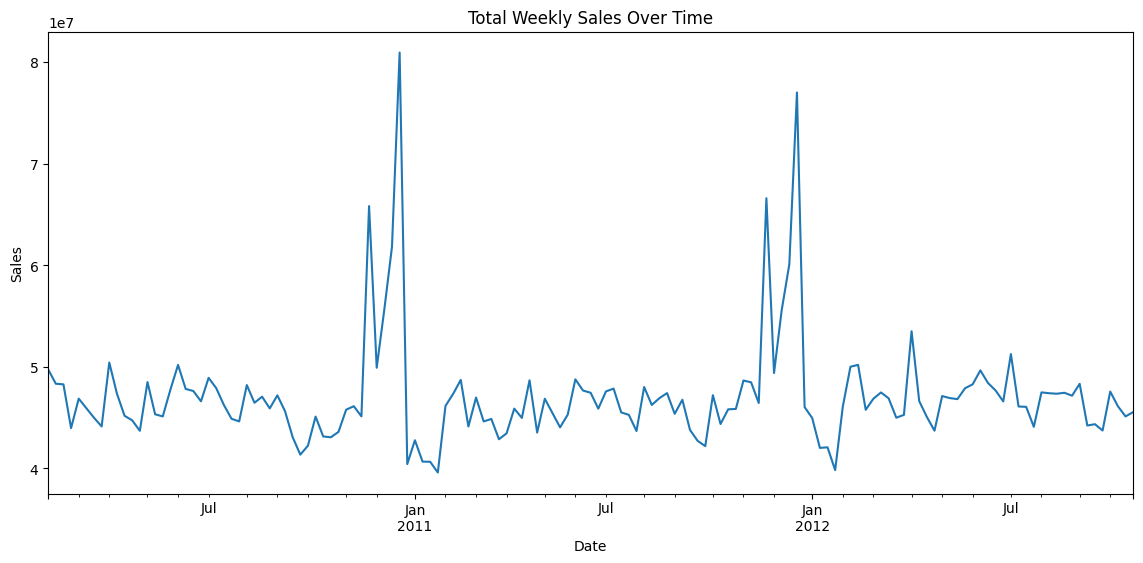

In [12]:
plt.figure(figsize=(14,6))
train.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title("Total Weekly Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()


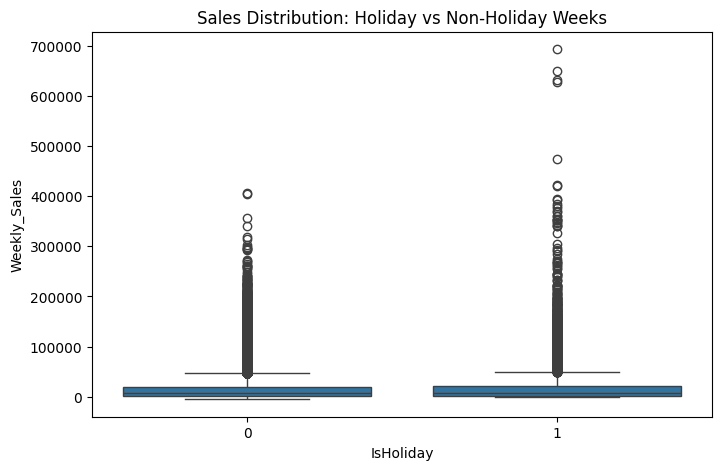

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=train)
plt.title("Sales Distribution: Holiday vs Non-Holiday Weeks")
plt.show()

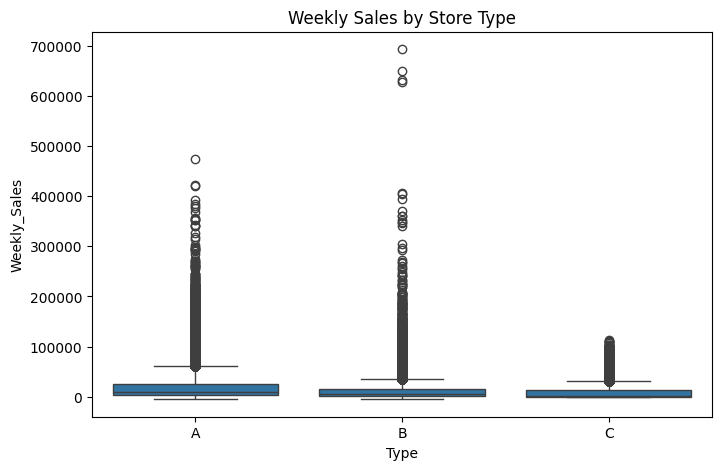

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Type', y='Weekly_Sales', data=train)
plt.title("Weekly Sales by Store Type")
plt.show()


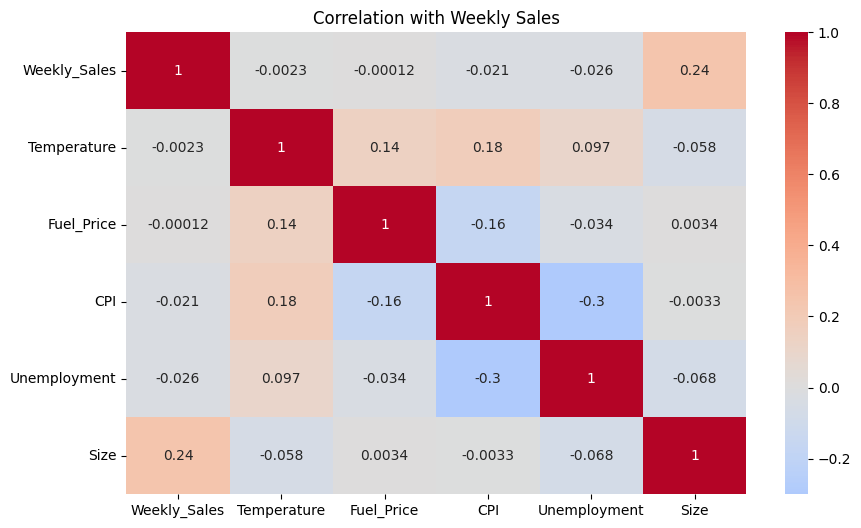

In [15]:
plt.figure(figsize=(10,6))
corr = train[['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation with Weekly Sales")
plt.show()


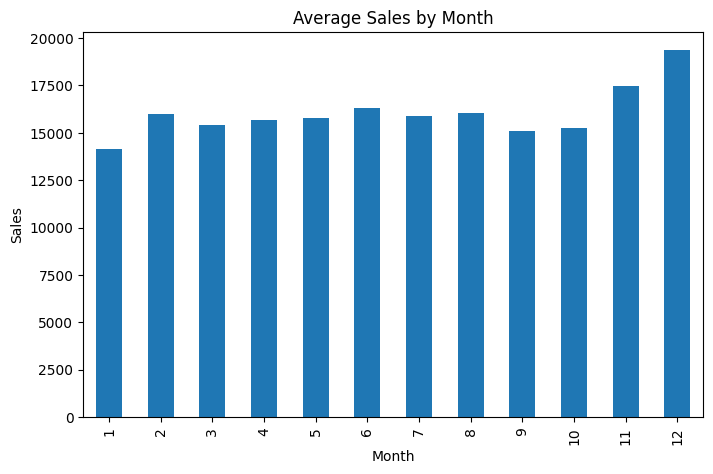

In [16]:
plt.figure(figsize=(8,5))
train.groupby('Month')['Weekly_Sales'].mean().plot(kind='bar')
plt.title("Average Sales by Month")
plt.ylabel("Sales")
plt.show()


# **Feature engineering (time-series)**

In [17]:

# Lag & Rolling Feature Maker

def make_lag_roll_features(train, test,
                           group_keys=('Store','Dept'),
                           target='Weekly_Sales',
                           lags=(1, 2, 52),          # 1 & 2 weeks, plus same week last year
                           rolls=(4, 12, 52)):       # 4, 12, 52-week rolling means
    """
    Returns new train, test with added lag & rolling features computed
    within each (Store, Dept) in strict time order.
    """
    # mark sets and combine so test can use history from train
    train = train.copy()
    test  = test.copy()
    train['__set__'] = 'train'
    test['__set__']  = 'test'

    both = pd.concat([train, test], axis=0, ignore_index=True)
    both = both.sort_values(list(group_keys) + ['Date']).reset_index(drop=True)

    # helper to build features within each group
    def _add_feats(g):
        y = g[target] if target in g.columns else None
        # Lags: shift by k weeks
        for k in lags:
            g[f'{target}_lag{k}'] = y.shift(k) if y is not None else np.nan

        # Rolling means over past window ONLY (shift first to exclude current week)
        for w in rolls:
            g[f'{target}_roll{w}'] = y.shift(1).rolling(window=w, min_periods=w).mean() if y is not None else np.nan
        return g

    # apply per group
    both = both.groupby(list(group_keys), group_keys=False, sort=False).apply(_add_feats)

    # split back
    train_new = both[both['__set__'] == 'train'].drop(columns='__set__')
    test_new  = both[both['__set__'] == 'test'].drop(columns='__set__')

    # After creation, drop early rows in train that don't have enough history
    created_cols = [c for c in train_new.columns if c.startswith(target+'_lag') or c.startswith(target+'_roll')]
    train_new = train_new.dropna(subset=created_cols)

    # For test, any remaining NaNs (rare, e.g., brand-new series) → fill per group median, then global median
    for c in created_cols:
        test_new[c] = (test_new.groupby(list(group_keys))[c]
                       .transform(lambda s: s.fillna(s.median())))
        test_new[c] = test_new[c].fillna(train_new[c].median())

    return train_new, test_new

# -------- run it --------
train_fe, test_fe = make_lag_roll_features(train, test)
print("Train shape:", train_fe.shape, " Test shape:", test_fe.shape)
train_fe.filter(regex='Weekly_Sales_(lag|roll)').head()


/tmp/ipython-input-2684719196.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  both = both.groupby(list(group_keys), group_keys=False, sort=False).apply(_add_feats)


Train shape: (261083, 28)  Test shape: (115064, 28)


,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag52,Weekly_Sales_roll4,Weekly_Sales_roll12,Weekly_Sales_roll52
52,18461.18,17341.47,24924.50,17286.6475,25087.749167,22990.294615
53,21665.76,18461.18,46039.49,18707.0275,25264.113333,22927.626538
54,37887.17,21665.76,41595.55,23838.8950,26791.974167,22770.851154
55,46845.87,37887.17,19403.54,31214.9950,29127.439167,22871.818846
56,19363.83,46845.87,21827.90,31440.6575,28864.628333,22871.055192


# **Feature selection & encoding**

In [18]:
# Copy so we don't overwrite
train_enc = train_fe.copy()
test_enc  = test_fe.copy()

# One-hot encode store Type (A/B/C)
train_enc = pd.get_dummies(train_enc, columns=['Type'], drop_first=True)
test_enc  = pd.get_dummies(test_enc,  columns=['Type'], drop_first=True)

# Align columns in train & test (in case one dummy is missing)
train_enc, test_enc = train_enc.align(test_enc, join='left', axis=1, fill_value=0)

# Drop columns not needed
drop_cols = ['Date', 'Weekly_Sales']  # Date is not numeric; Weekly_Sales is target
X = train_enc.drop(columns=drop_cols, errors='ignore')
y = train_enc['Weekly_Sales']

# For test, keep features only
X_test = test_enc.drop(columns=drop_cols, errors='ignore')

print("Train features shape:", X.shape)
print("Test features shape:", X_test.shape)


Train features shape: (261083, 27)
Test features shape: (115064, 27)


# **Time-aware validation**

In [19]:
# Pick a cutoff date at the last ~10% of the timeline
unique_dates = np.array(sorted(train_fe['Date'].unique()))
cut_idx = int(len(unique_dates) * 0.90)   # 90% train, 10% validation
cutoff_date = unique_dates[cut_idx]
print("Cutoff date for validation:", cutoff_date)

# Boolean masks for train/valid
mask_train = train_fe['Date'] < cutoff_date
mask_valid = train_fe['Date'] >= cutoff_date

# Apply masks to features/target
X_train, y_train = X[mask_train], y[mask_train]
X_valid, y_valid = X[mask_valid], y[mask_valid]

print("Train range:", train_fe.loc[mask_train, 'Date'].min(), "→", train_fe.loc[mask_train, 'Date'].max())
print("Valid range:", train_fe.loc[mask_valid, 'Date'].min(), "→", train_fe.loc[mask_valid, 'Date'].max())
print("Shapes: Train =", X_train.shape, " Valid =", X_valid.shape)


Cutoff date for validation: 2012-08-24 00:00:00
Train range: 2011-02-04 00:00:00 → 2012-08-17 00:00:00
Valid range: 2012-08-24 00:00:00 → 2012-10-26 00:00:00
Shapes: Train = (231910, 27)  Valid = (29173, 27)


# **Modeling & evaluation**

## **Linear Regression**

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize model
lr = LinearRegression()

# Fit on training data
lr.fit(X_train, y_train)

# Predict
y_pred_train = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)

# Evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_valid = mean_absolute_error(y_valid, y_pred_valid)

r2_train = r2_score(y_train, y_pred_train)
r2_valid = r2_score(y_valid, y_pred_valid)

print("Linear Regression Performance:")
print(f"Train -> RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.3f}")
print(f"Valid -> RMSE: {rmse_valid:.2f}, MAE: {mae_valid:.2f}, R²: {r2_valid:.3f}")


Linear Regression Performance:
Train -> RMSE: 3760.40, MAE: 1688.12, R²: 0.973
Valid -> RMSE: 3039.54, MAE: 1521.54, R²: 0.981


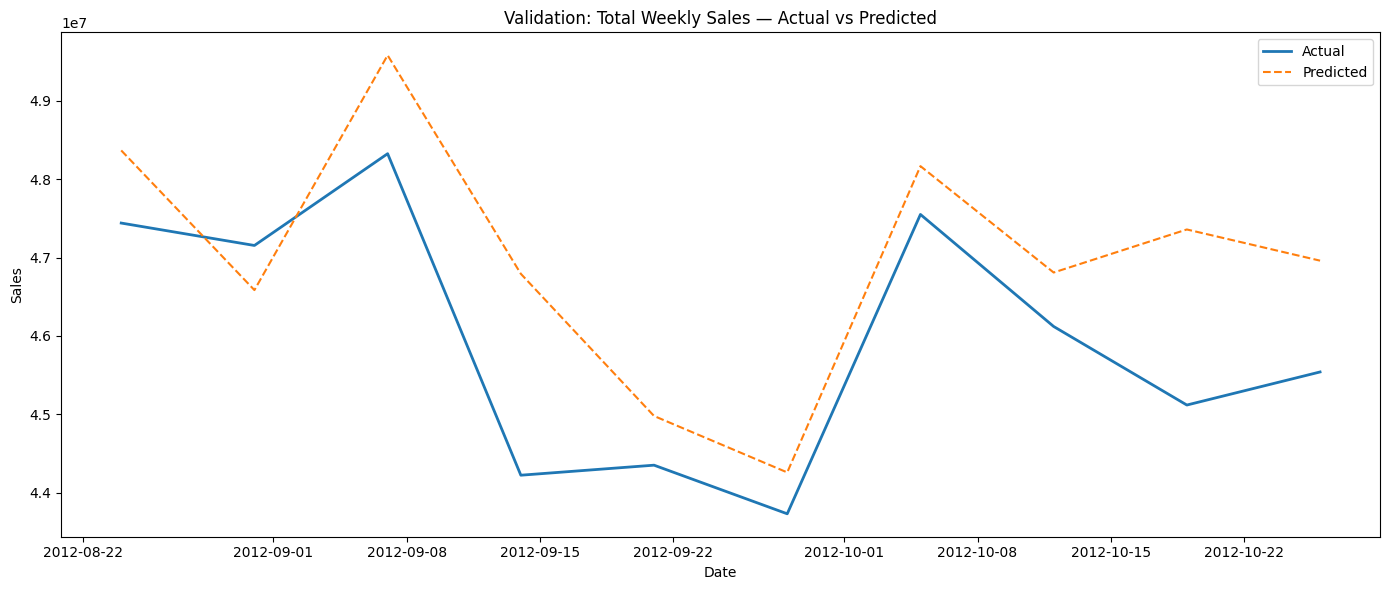

In [21]:
# Build a validation frame with actuals & predictions
valid_df = train_fe.loc[mask_valid, ['Date','Store','Dept','Weekly_Sales']].copy()
valid_df['Pred'] = y_pred_valid

# Aggregate by week to see overall fit
agg = (valid_df.groupby('Date')[['Weekly_Sales','Pred']]
       .sum()
       .reset_index())

plt.figure(figsize=(14,6))
plt.plot(agg['Date'], agg['Weekly_Sales'], label='Actual', linewidth=2)
plt.plot(agg['Date'], agg['Pred'], label='Predicted', linestyle='--')
plt.title('Validation: Total Weekly Sales — Actual vs Predicted')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.legend(); plt.tight_layout()
plt.show()


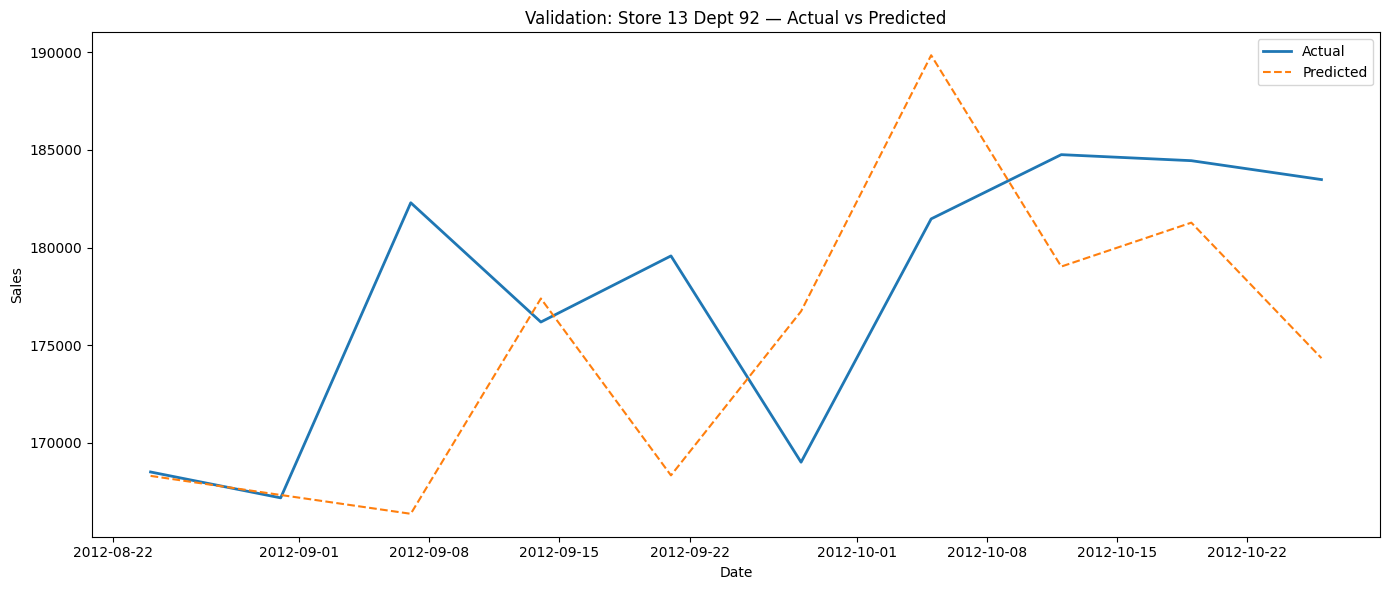

In [22]:
# Choose a representative (Store, Dept) — the one with the most sales in the valid window
top_pair = (valid_df.groupby(['Store','Dept'])['Weekly_Sales'].sum()
            .sort_values(ascending=False).index[0])

pair_df = (valid_df.loc[(valid_df['Store']==top_pair[0]) & (valid_df['Dept']==top_pair[1])]
           .sort_values('Date'))

plt.figure(figsize=(14,6))
plt.plot(pair_df['Date'], pair_df['Weekly_Sales'], label='Actual', linewidth=2)
plt.plot(pair_df['Date'], pair_df['Pred'], label='Predicted', linestyle='--')
plt.title(f'Validation: Store {top_pair[0]} Dept {top_pair[1]} — Actual vs Predicted')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.legend(); plt.tight_layout()
plt.show()


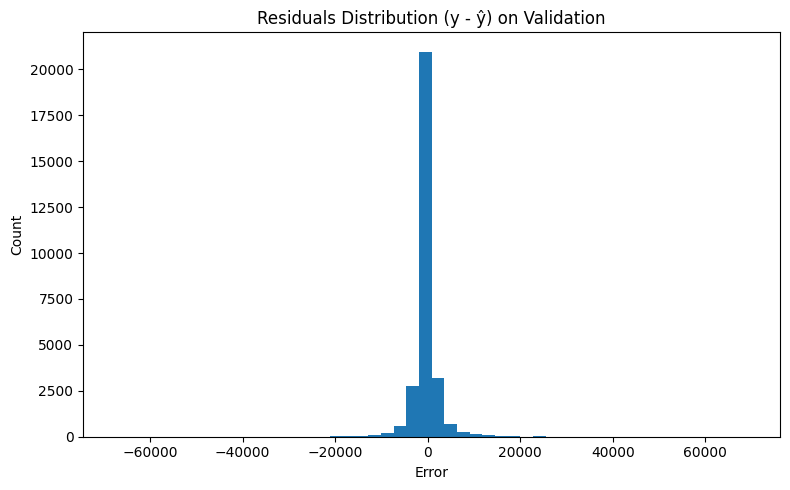

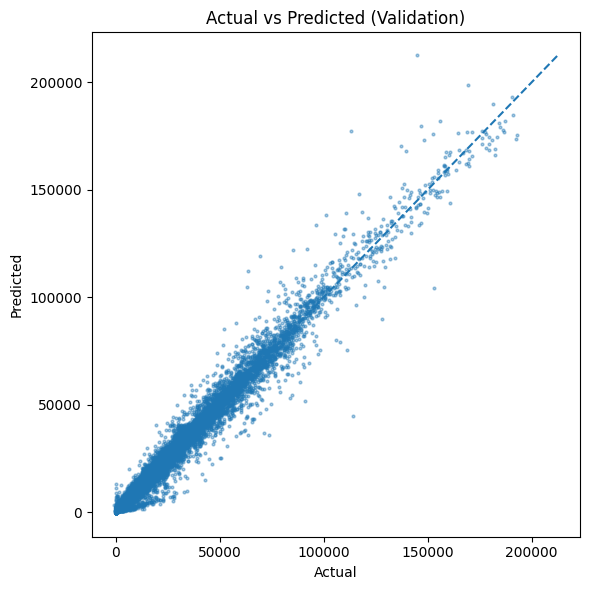

In [23]:
resid = y_valid - y_pred_valid

# Residual distribution
plt.figure(figsize=(8,5))
plt.hist(resid, bins=50)
plt.title('Residuals Distribution (y - ŷ) on Validation')
plt.xlabel('Error'); plt.ylabel('Count'); plt.tight_layout()
plt.show()

# Actual vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_pred_valid, s=4, alpha=0.4)
lims = [min(y_valid.min(), y_pred_valid.min()), max(y_valid.max(), y_pred_valid.max())]
plt.plot(lims, lims, '--')  # 45° perfect line
plt.title('Actual vs Predicted (Validation)')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.tight_layout()
plt.show()


## **Gradient Boosting (Advanced)**

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_valid)

# Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
r2_xgb = r2_score(y_valid, y_pred_xgb)

print("XGBoost Performance:")
print(f"Valid -> RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.3f}")


XGBoost Performance:
Valid -> RMSE: 2710.62, MAE: 1290.72, R²: 0.985


## **LightGBM**

In [25]:
import lightgbm as lgb


lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_model.predict(X_valid)

# Metrics
rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_pred_lgb))
mae_lgb = mean_absolute_error(y_valid, y_pred_lgb)
r2_lgb = r2_score(y_valid, y_pred_lgb)

print("LightGBM Performance:")
print(f"Valid -> RMSE: {rmse_lgb:.2f}, MAE: {mae_lgb:.2f}, R²: {r2_lgb:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4018
[LightGBM] [Info] Number of data points in the train set: 231910, number of used features: 26
[LightGBM] [Info] Start training from score 16476.446767
LightGBM Performance:
Valid -> RMSE: 2719.74, MAE: 1281.75, R²: 0.985


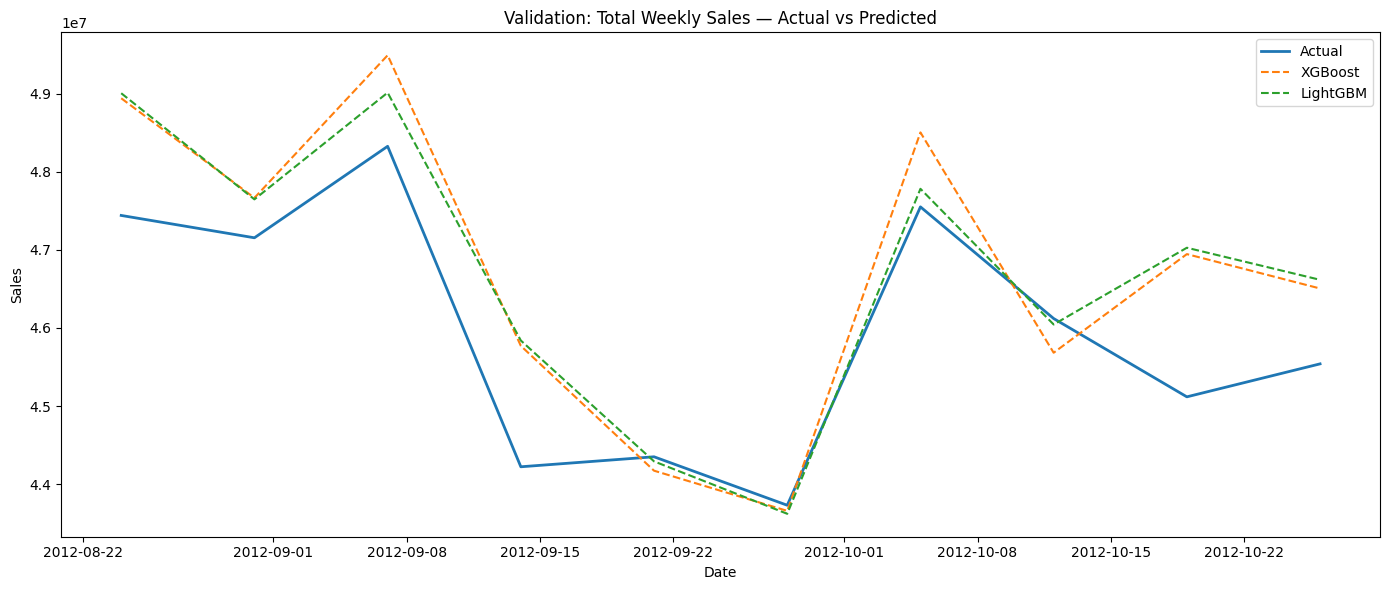

In [26]:
# Validation DataFrame with predictions
valid_df_xgb = train_fe.loc[mask_valid, ['Date','Store','Dept','Weekly_Sales']].copy()
valid_df_xgb['Pred_XGB'] = y_pred_xgb
valid_df_xgb['Pred_LGB'] = y_pred_lgb

# Aggregate weekly totals
agg_xgb = valid_df_xgb.groupby('Date')[['Weekly_Sales','Pred_XGB','Pred_LGB']].sum().reset_index()

plt.figure(figsize=(14,6))
plt.plot(agg_xgb['Date'], agg_xgb['Weekly_Sales'], label='Actual', linewidth=2)
plt.plot(agg_xgb['Date'], agg_xgb['Pred_XGB'], '--', label='XGBoost')
plt.plot(agg_xgb['Date'], agg_xgb['Pred_LGB'], '--', label='LightGBM')
plt.title("Validation: Total Weekly Sales — Actual vs Predicted")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout()
plt.show()


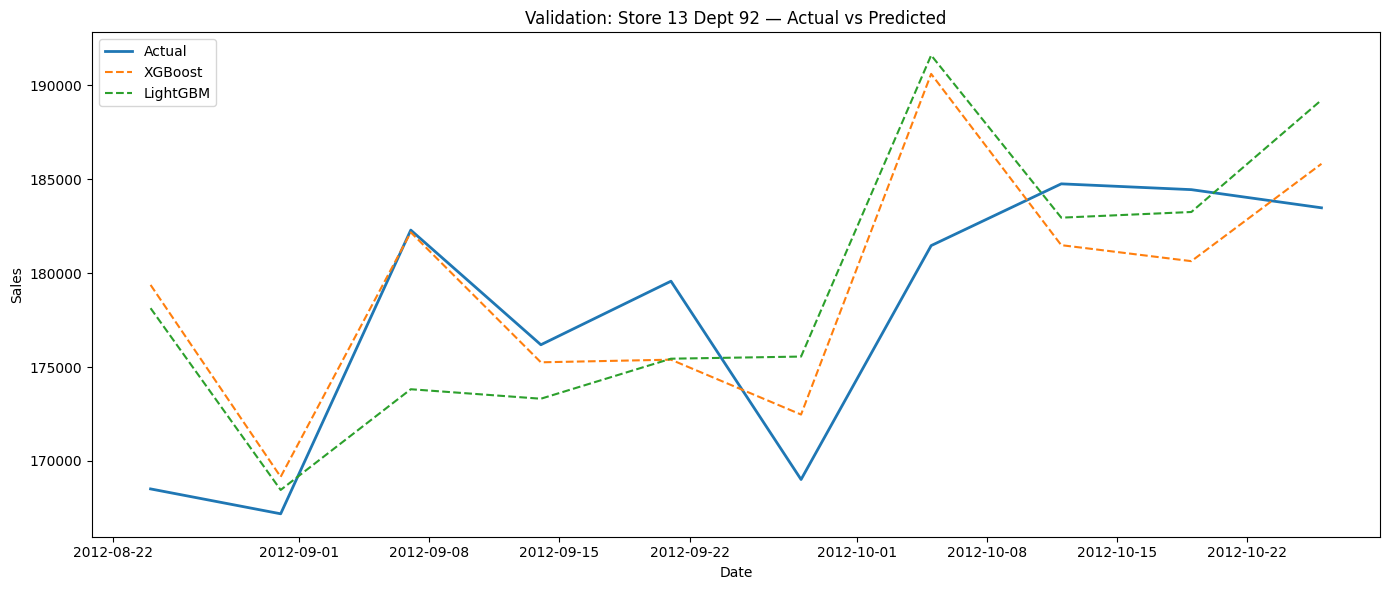

In [27]:
# Pick the top store-dept again
top_pair = (valid_df_xgb.groupby(['Store','Dept'])['Weekly_Sales']
            .sum().sort_values(ascending=False).index[0])

pair_df = valid_df_xgb[(valid_df_xgb['Store']==top_pair[0]) & (valid_df_xgb['Dept']==top_pair[1])]
pair_df = pair_df.sort_values('Date')

plt.figure(figsize=(14,6))
plt.plot(pair_df['Date'], pair_df['Weekly_Sales'], label='Actual', linewidth=2)
plt.plot(pair_df['Date'], pair_df['Pred_XGB'], '--', label='XGBoost')
plt.plot(pair_df['Date'], pair_df['Pred_LGB'], '--', label='LightGBM')
plt.title(f"Validation: Store {top_pair[0]} Dept {top_pair[1]} — Actual vs Predicted")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout()
plt.show()


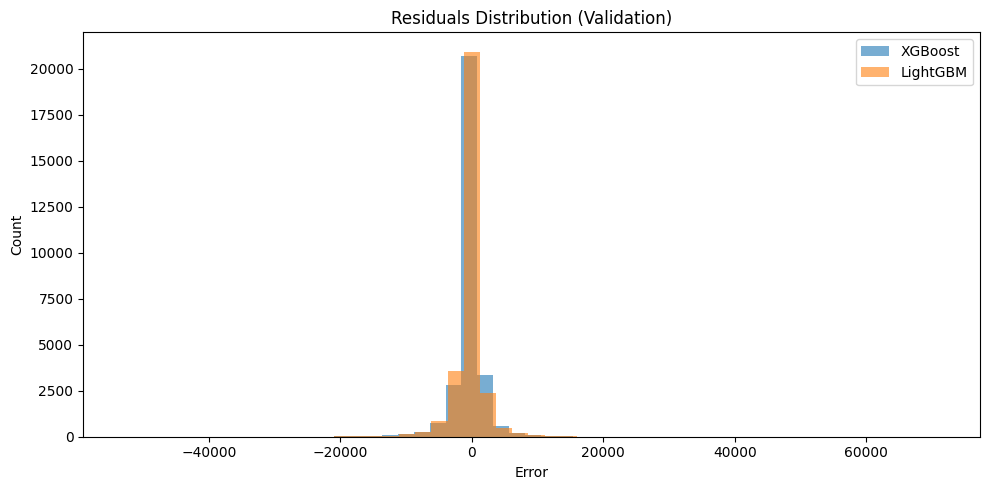

In [28]:
resid_xgb = y_valid - y_pred_xgb
resid_lgb = y_valid - y_pred_lgb

plt.figure(figsize=(10,5))
plt.hist(resid_xgb, bins=50, alpha=0.6, label='XGBoost')
plt.hist(resid_lgb, bins=50, alpha=0.6, label='LightGBM')
plt.title("Residuals Distribution (Validation)")
plt.xlabel("Error"); plt.ylabel("Count"); plt.legend(); plt.tight_layout()
plt.show()


In [29]:
# -----------------------
# Final Predictions on Test Set
# -----------------------

# Predict with both models
test_pred_xgb = xgb_model.predict(X_test)
test_pred_lgb = lgb_model.predict(X_test)

# Build submission DataFrame
submission = df_test[['Store','Dept','Date']].copy()
submission['Weekly_Sales_XGB'] = test_pred_xgb
submission['Weekly_Sales_LGB'] = test_pred_lgb

# Save to CSV
submission.to_csv("walmart_sales_forecast.csv", index=False)

print("Submission file saved as walmart_sales_forecast.csv")
submission.head()


Submission file saved as walmart_sales_forecast.csv


,Store,Dept,Date,Weekly_Sales_XGB,Weekly_Sales_LGB
0,1,1,2012-11-02,37140.652344,36338.438817
1,1,1,2012-11-09,26490.382812,22093.337063
2,1,1,2012-11-16,26218.429688,23272.339749
3,1,1,2012-11-23,30378.978516,28199.886140
4,1,1,2012-11-30,30651.736328,28212.809786


# **Bonus: Seasonal decomposition**

Weeks available: 143


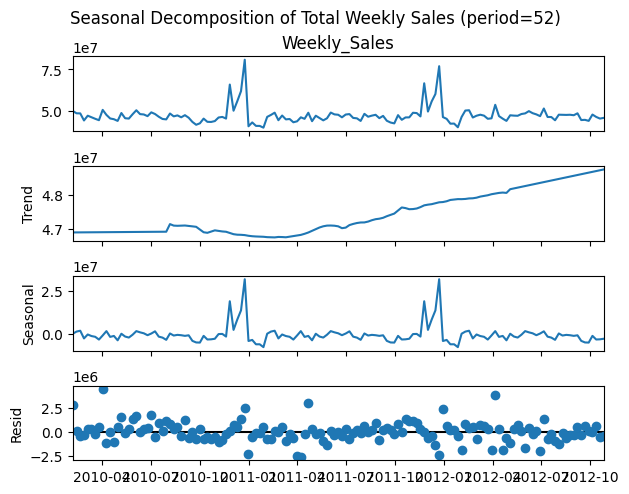

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# use the original train CSV (full history)
weekly_sales_full = (
    df_train.assign(Date=pd.to_datetime(df_train['Date']))
            .groupby('Date')['Weekly_Sales'].sum()
            .sort_index()
)

print("Weeks available:", len(weekly_sales_full))  # should be >= 104

decomp = seasonal_decompose(
    weekly_sales_full,
    model='additive',
    period=52,
    extrapolate_trend='freq'
)
decomp.plot()
plt.suptitle("Seasonal Decomposition of Total Weekly Sales (period=52)", y=1.02)
plt.show()


# **Conclusion**

Using advanced models (XGBoost & LightGBM) with time-based features, we achieved very high accuracy (R² ≈ 0.985) in forecasting Walmart’s weekly sales. The models successfully captured seasonal spikes (holidays, December) and store-level differences, outperforming the linear baseline. These forecasts enable Walmart to better manage inventory, plan revenue, and align promotions with demand peaks, ultimately reducing losses and improving investor confidence.